In [ ]:
# Mount drive for data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#imports
import glob, os
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading and cleaning the data


In [ ]:
# Load in filtered data
input_params = pd.read_csv("/content/drive/MyDrive/ml_final_project_pc170a/nn_input_params.csv")
cosmo_params = pd.read_csv("/content/drive/MyDrive/ml_final_project_pc170a/latin_hypercube_params.csv")

#loading data from runtime

#input_params = pd.read_csv('/content/nn_input_params.csv')
#cosmo_params = pd.read_csv('/content/latin_hypercube_params.csv')

cosmo_params=cosmo_params.drop(columns=['Unnamed: 0'],axis=1)

In [ ]:
'''cosmo_params=cosmo_params.drop(columns=['Unnamed: 0'],axis=1)
input_params = input_params.drop(["Unnamed: 0"], axis=1)
print(input_params.shape)

# Find NaN rows in data
nan_df = input_params[input_params.isna().any(axis=1)]
#print(nan_df)
drop_this_index = nan_df["index"].drop_duplicates()
print(drop_this_index)

# TODO: Only 1 catalog has no values, so we can drop the corresponding row in the comsological params file
index_values = input_params["index"].drop_duplicates()
index_values = np.array(index_values)
drop_this_row = list(index_values).index(1897)
print("Row to be dropped:", drop_this_row)
cosmo_params = cosmo_params.drop(drop_this_row)'''

'cosmo_params=cosmo_params.drop(columns=[\'Unnamed: 0\'],axis=1)\ninput_params = input_params.drop(["Unnamed: 0"], axis=1)\nprint(input_params.shape)\n\n# Find NaN rows in data\nnan_df = input_params[input_params.isna().any(axis=1)]\n#print(nan_df)\ndrop_this_index = nan_df["index"].drop_duplicates()\nprint(drop_this_index)\n\n# TODO: Only 1 catalog has no values, so we can drop the corresponding row in the comsological params file\nindex_values = input_params["index"].drop_duplicates()\nindex_values = np.array(index_values)\ndrop_this_row = list(index_values).index(1897)\nprint("Row to be dropped:", drop_this_row)\ncosmo_params = cosmo_params.drop(drop_this_row)'

In [ ]:
# Find and drop NaNs in data
nan_df = input_params[input_params.isna().any(axis=1)]
drop_this_index = nan_df["index"].drop_duplicates().values[0]

cosmo_params = cosmo_params.drop(drop_this_index)

input_params = input_params.dropna()

##Creating the histograms from the data of each of the parameters

In [ ]:
# Extract voids from each catalogue!
ellip_data = []
rad_data = []
dens_data = []

ellip_bins = [(i / 18) * 1 for i in range(0, 19)]
rad_bins = [(i / 18) * 650 for i in range(0, 19)]
dens_bins = [1 + (i / 18) * 2 for i in range(0, 19)]

for i in np.unique(input_params['index']):
  void_catalogue = input_params[input_params['index'] == i]

  ellipticity, radius, density_contrast = void_catalogue['ellipticity'].values, void_catalogue['radius'].values, void_catalogue['density_contrast'].values

# add later as a hyperparameter
  #norm_ellip = (ellipticity - np.mean(ellipticity)) / np.mean(ellipticity)
  #norm_rad = (radius - np.mean(radius)) / np.mean(radius)
  #norm_dens = (density_contrast - np.mean(density_contrast)) / np.mean(density_contrast)

  ellip_hist = np.histogram(ellipticity, bins=ellip_bins, range=(0,1))[0]
  rad_hist = np.histogram(radius, bins=rad_bins, range=(0,650))[0]
  dens_hist = np.histogram(density_contrast, bins=dens_bins, range=(1,3))[0] # maybe do 1 to 5?

  ellip_density = ellip_hist/ len(ellipticity)
  rad_density = rad_hist/ len(radius)
  dens_density = dens_hist/ len(density_contrast)

  ellip_data.append(ellip_density)
  rad_data.append(rad_density)
  dens_data.append(dens_density)

ellip_data = np.array(ellip_data)
rad_data = np.array(rad_data)
dens_data = np.array(dens_data)

##separating the data into train, test and validation data

In [ ]:
from sklearn.model_selection import train_test_split

# Setting the parameters and targets into dataframes for easy separation
ellip_hist_df = pd.DataFrame(ellip_data)
rad_hist_df = pd.DataFrame(rad_data)
dens_data_df = pd.DataFrame(dens_data)

target_params = cosmo_params


def split_data(features, targets):
    train_features, temp_features, train_targets, temp_targets = train_test_split(features, targets, test_size=0.2, random_state=42)
    test_features, val_features, test_targets, val_targets = train_test_split(temp_features, temp_targets, test_size=0.5, random_state=42)
    return train_features, test_features, val_features, train_targets, test_targets, val_targets

# Splitting ellip data
x_train_ellip, x_test_ellip, x_val_ellip, y_train, y_test, y_val = split_data(ellip_hist_df, target_params)

# Splitting rad data
x_train_rad, x_test_rad, x_val_rad, _, _, _ = split_data(rad_hist_df, target_params)

# Splitting dens data
x_train_dens, x_test_dens, x_val_dens, _, _, _ = split_data(dens_data_df, target_params)

## Data for full model

In [ ]:
big_data = np.hstack((ellip_data, rad_data, dens_data))

X_train, X_test, y_train_full, y_test_full = train_test_split(big_data, cosmo_params, test_size=0.2, random_state=42)


#Neural Networks'

###imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras import Model
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import AdamW
from keras.models import Sequential
from tensorflow.math import log
from tensorflow.math import reduce_mean
from tensorflow.math import square
from tensorflow.math import reduce_sum

###Custom Loss Function

In [ ]:
def custom_loss(y_true, y_pred):
  y_nn = y_pred[:, 0]
  e_nn = y_pred[:, 1]

  loss1 = reduce_mean(square(y_true - y_nn))
  loss2 = reduce_mean(square(square(y_true - y_nn) - square(e_nn)))
  loss = reduce_mean(log(loss1) + log(loss2))
  return loss

bs = 64

def custom_loss5(y_true, y_pred):
  y_nn = y_pred[:, 0:5]
  e_nn = y_pred[:, 5:]

  loss1 = reduce_mean(square(y_true - y_nn))
  loss2 = reduce_mean(square(square(y_true - y_nn) - square(e_nn)))
  loss = reduce_mean(log(loss1) + log(loss2))
  return loss

def custom_loss31(y_true, y_pred):
  y_nn = y_pred[:, 0]
  e_nn = y_pred[:, 1]

  loss1 = reduce_mean(square(y_true - y_nn))
  loss2 = reduce_mean(square(square(y_true - y_nn) - e_nn**2))
  loss = reduce_mean(log(loss1) + log(loss2))
  return loss

def custom_loss1(y_true, y_pred):
  y_nn = y_pred[:, 0]
  e_nn = y_pred[:, 1]

  loss1 = reduce_mean(square(y_true - y_nn))
  loss2 = reduce_mean(square(square(y_true - y_nn) - square(e_nn)))
  loss = reduce_mean(log(loss1) + log(loss2))

  train_loss1 += loss1 * bs
  train_loss2 += loss2 * bs
  points += bs
  i += 1
  train_loss = reduce_mean(log(train_loss1 / points) + log(train_loss2 / points))

  return train_loss

##Model Creation

###One feature paramater to one target parameter NN model

In [ ]:
def create_model():
    model = Sequential()

    model.add(Input(shape=(18,)))
    model.add(Dense(100, activation='leaky_relu'))

    for i in range(0, 3):
        model.add(Dense(100, activation='leaky_relu'))

    model.add(Dropout(0.2))
    model.add(Dense(2, name='output'))

    adamw = Adam(learning_rate=0.0005, weight_decay=0.001)
    model.compile(loss='mean_squared_error', optimizer=adamw)

    return model

In [ ]:
omega_m_model = create_model()
omega_m_model.summary()

Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_296 (Dense)           (None, 100)               1900      
                                                                 
 dense_297 (Dense)           (None, 100)               10100     
                                                                 
 dense_298 (Dense)           (None, 100)               10100     
                                                                 
 dense_299 (Dense)           (None, 100)               10100     
                                                                 
 dropout_78 (Dropout)        (None, 100)               0         
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
Total params: 32402 (126.57 KB)
Trainable params: 324

In [ ]:
#omega_m_model.fit(x_train_ellip, y_train['omega_m'], batch_size=32, epochs=500)
history = omega_m_model.fit(x_train_ellip, y_train['omega_m'], epochs=1000, batch_size=128, validation_data=(x_val_ellip, y_val['omega_m']), verbose=1)

Epoch 1/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.0692 - val_loss: 0.0100
Epoch 2/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0055
Epoch 3/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0038
Epoch 4/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 5/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0036
Epoch 6/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 7/1000
13/13 [==============================] - 0s 8ms/step - loss: 0.0051 - val_loss: 0.0035
Epoch 8/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 9/1000
13/13 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 10/1000
13/13 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.003

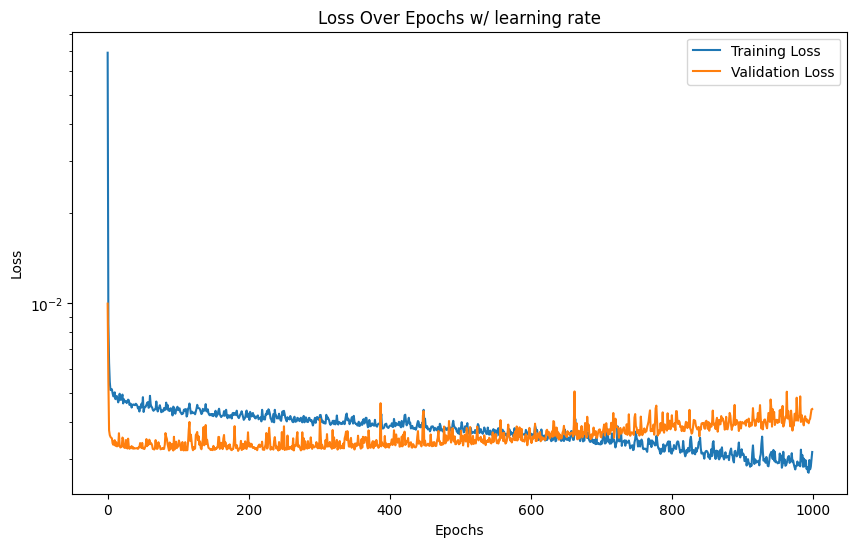

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss Over Epochs w/ learning rate')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predictions_om = omega_m_model.predict(x_test_ellip)

mae_om = mean_absolute_error(y_test['omega_m'], predictions_om[:, 0])
mse_om = mean_squared_error(y_test['omega_m'], predictions_om[:, 0])
rmse_om = np.sqrt(mse_om)
r2_om = r2_score(y_test['omega_m'], predictions_om[:, 0])

print(f"\nMean Absolute Error (MAE): {mae_om}")
print(f"Mean Squared Error (MSE): {mse_om}")
print(f"Root Mean Squared Error (RMSE): {rmse_om}")
print(f"R-squared: {r2_om}")

7/7 [==============================] - 0s 2ms/step

Mean Absolute Error (MAE): 0.06560740110778808
Mean Squared Error (MSE): 0.00705537170721758
Root Mean Squared Error (RMSE): 0.08399626007875338
R-squared: 0.4506603346807255


#### grid search model for later

In [ ]:
#Model creation for grid search use later
'''from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def create_model(input_shape, num_parameters, hidden_layers, neurons, dropout_rate, learning_rate):
    model = Sequential()

    # Input and hidden layers
    for i in range(hidden_layers):
        if i == 0:
            model.add(Dense(neurons, input_shape=(input_shape,), activation=LeakyReLU(alpha=0.01)))
        else:
            model.add(Dense(neurons, activation=LeakyReLU(alpha=0.01)))
        model.add(Dropout(dropout_rate))

    # Output layer
    # Output has 2 values per parameter: one for the posterior mean and one for the posterior standard deviation
    model.add(Dense(num_parameters * 2, activation=None))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')  # Using MSE as a placeholder loss function

    return model

# Model configuration based on Wang et al. paper
input_shape = 18  # Number of bins in the histogram
num_parameters = 1  # Inferring one parameter (Ωm)
hidden_layers = 3  # Number of hidden layers
neurons = 128  # Number of neurons in each hidden layer
dropout_rate = 0.01  # Dropout rate
learning_rate = 1e-5  # Learning rate

# Build the model
model = create_model(input_shape, num_parameters, hidden_layers, neurons, dropout_rate, learning_rate)

model.summary()'''

### 3 feature parameters to 1 target nn model

In [ ]:
from tensorflow.keras.layers import LeakyReLU

def build_model():
  input_ellip = Input(shape=(18,), name='ellip')
  input_rad = Input(shape=(18,), name='rad')
  input_dens = Input(shape=(18,), name='dens')

  concat = tf.keras.layers.concatenate([input_ellip, input_rad, input_dens])

  dense = Dense(100, activation=LeakyReLU(alpha=0.01))(concat)
  dense = Dense(100, activation=LeakyReLU(alpha=0.01))(dense)

  dropout = Dropout(0.2)(dense)

  out = Dense(2, name='params')(dropout)

  pfxn = Model([input_ellip, input_rad, input_dens], [out], name='pfxn')

  adamw = Adam(learning_rate=0.0005, weight_decay=0.01)
  pfxn.compile(optimizer=adamw, loss='mean_squared_logarithmic_error')

  return pfxn

In [ ]:
om3 = build_model()
om3.summary()

Model: "pfxn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ellip (InputLayer)          [(None, 18)]                 0         []                            
                                                                                                  
 rad (InputLayer)            [(None, 18)]                 0         []                            
                                                                                                  
 dens (InputLayer)           [(None, 18)]                 0         []                            
                                                                                                  
 concatenate_7 (Concatenate  (None, 54)                   0         ['ellip[0][0]',               
 )                                                                   'rad[0][0]',              

In [ ]:
#{'learning_rate': 4.3196663264017274e-05, 'weight_decay': 0.00011277026797032308}.

In [ ]:
history = om3.fit({'ellip': x_train_ellip, 'rad': x_train_rad, 'dens': x_train_dens}, {'params': y_train['omega_m']}, epochs=1000, batch_size=128, validation_data=({'ellip': x_val_ellip, 'rad': x_val_rad, 'dens': x_val_dens}, y_val['omega_m']), verbose=1)

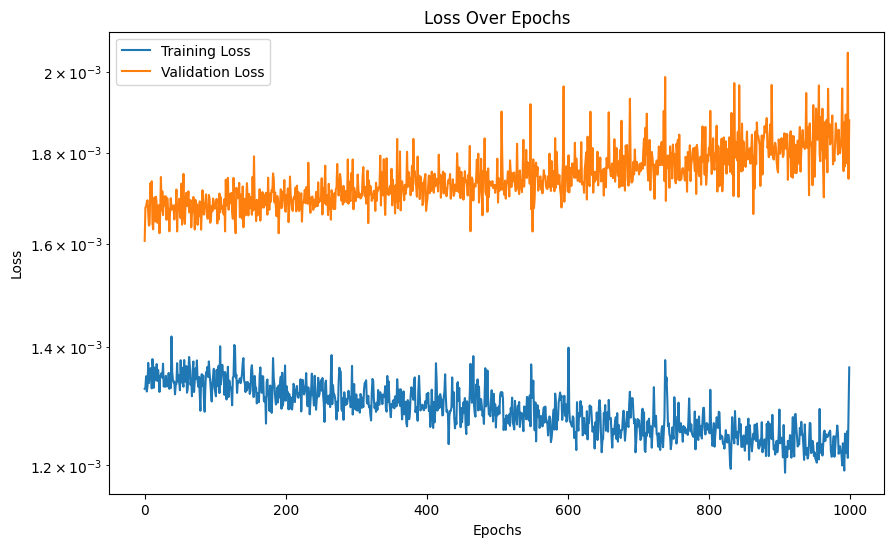

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
predictions_om = om3.predict({'ellip': x_test_ellip, 'rad': x_test_rad, 'dens': x_test_dens})

mae_om = mean_absolute_error(y_test['sigma_8'], predictions_om[:, 0])
mse_om = mean_squared_error(y_test['sigma_8'], predictions_om[:, 0])
rmse_om = np.sqrt(mse_om)
r2_om = r2_score(y_test['sigma_8'], predictions_om[:, 0])

print(f"\nMean Absolute Error (MAE): {mae_om}")
print(f"Mean Squared Error (MSE): {mse_om}")
print(f"Root Mean Squared Error (RMSE): {rmse_om}")
print(f"R-squared: {r2_om}")

7/7 [==============================] - 0s 2ms/step

Mean Absolute Error (MAE): 0.04159372248029709
Mean Squared Error (MSE): 0.0028196187072405316
Root Mean Squared Error (RMSE): 0.05310008198901892
R-squared: 0.7746264867674442


### 3 Features (radius, ellipticity and density contrast histograms) and 3 target features ($Ω_m$, $n_s$ and $\sigma_8$) NN model


In [ ]:
def create_model5():
    model = Sequential()

    model.add(Input(shape=(54,)))
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.2))

    for i in range(0, 3):
        model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(10, name='output'))

    adamw = Adam(learning_rate=0.0002, weight_decay=0.0001)
    model.compile(loss=custom_loss5, optimizer=adamw) #loss=custom_loss5

    return model

In [ ]:
full_model = create_model5()
full_model.summary()

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_286 (Dense)           (None, 100)               5500      
                                                                 
 dense_287 (Dense)           (None, 100)               10100     
                                                                 
 dense_288 (Dense)           (None, 100)               10100     
                                                                 
 dense_289 (Dense)           (None, 100)               10100     
                                                                 
 dropout_75 (Dropout)        (None, 100)               0         
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 36810 (143.79 KB)
Trainable params: 368

In [ ]:
full_model.fit(X_train, y_train_full, batch_size=bs, epochs=2)

Epoch 1/2
25/25 [==============================] - 4s 3ms/step - loss: -2.3520
Epoch 2/2
25/25 [==============================] - 0s 3ms/step - loss: -5.0079


In [ ]:
#history = omega_m_model.fit(X_train, y_train_full, epochs=1000, batch_size=128, validation_data=( X_test, y_test_full ), verbose=1)
history = full_model.fit(X_train, y_train_full, epochs=1000, batch_size=128, validation_data=(X_test, y_test_full), verbose=1)

Epoch 1/1000
13/13 [==============================] - 0s 25ms/step - loss: -7.6173 - val_loss: -9.6017
Epoch 2/1000
13/13 [==============================] - 0s 7ms/step - loss: -9.0442 - val_loss: -11.8934
Epoch 3/1000
13/13 [==============================] - 0s 6ms/step - loss: -10.2955 - val_loss: -13.1926
Epoch 4/1000
13/13 [==============================] - 0s 9ms/step - loss: -10.6290 - val_loss: -13.2102
Epoch 5/1000
13/13 [==============================] - 0s 6ms/step - loss: -10.8416 - val_loss: -13.3311
Epoch 6/1000
13/13 [==============================] - 0s 7ms/step - loss: -10.9002 - val_loss: -13.1720
Epoch 7/1000
13/13 [==============================] - 0s 7ms/step - loss: -11.0964 - val_loss: -13.1848
Epoch 8/1000
13/13 [==============================] - 0s 6ms/step - loss: -11.1146 - val_loss: -13.3802
Epoch 9/1000
13/13 [==============================] - 0s 7ms/step - loss: -11.2112 - val_loss: -13.3830
Epoch 10/1000
13/13 [==============================] - 0s 8ms/step

<ipython-input-84-5cfc5f09c6fc>:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


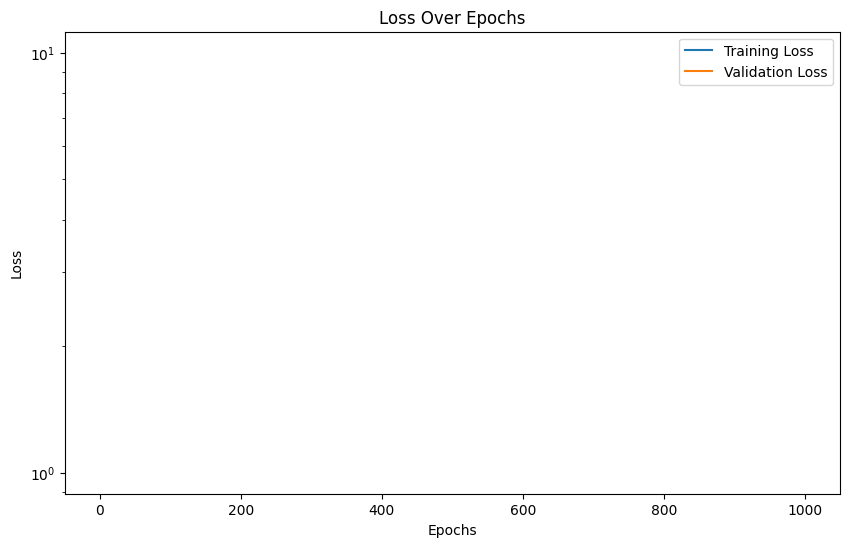

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predictions_fm = full_model.predict(X_test)

mae_full = mean_absolute_error(y_test_full, predictions_fm[:, 0:5])
mse_full = mean_squared_error(y_test_full, predictions_fm[:, 0:5])
rmse_full = np.sqrt(mse_full)
r2_all = r2_score(y_test_full, predictions_fm[:, 0:5])

print(f"Mean Absolute Error (MAE): {mae_full}")
print(f"Mean Squared Error (MSE): {mse_full}")
print(f"Root Mean Squared Error (RMSE): {rmse_full}")
print(f"R-squared: {r2_all}")

13/13 [==============================] - 0s 5ms/step
Mean Absolute Error (MAE): 0.05567471065728189
Mean Squared Error (MSE): 0.005981719470441316
Root Mean Squared Error (RMSE): 0.07734157659655844
R-squared: 0.3552960786783491


#Hyperparameter tunning with grid search

$$ param_grid = {
    'learning_rate': [1e-3, 1e-4, 1e-5, 1e-6],
    'weight_decay': [0.01, 0.001, 0.0001, 0.00001],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],
    'batch_size': [32, 64, 128],
    'epochs': [50, 100, 150, 200,500,1000]
} # $$


## Imports and instalations

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import mean_squared_error

## One feature parameter to one target parameter nn model grid search hyperparameter tuning Amen

In [ ]:
# Define the model builder function

def create_model(learning_rate=0.0005, weight_decay=0.01):
    model = Sequential()

    model.add(Input(shape=(18,)))
    model.add(Dense(100, activation='leaky_relu'))

    for i in range(0, 3):
        model.add(Dense(100, activation='leaky_relu'))

    model.add(Dropout(0.2))
    model.add(Dense(2, name='output'))

    adamw = Adam(learning_rate = learning_rate , weight_decay = weight_decay)
    model.compile(loss='mean_squared_error', optimizer=adamw)

    return model


#define the regression wrapper that searches for the best fit over the grid

class RegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.01, weight_decay=0.001,batch_size=64,epochs=500):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None

    def create_model(self):
        return create_model(learning_rate=self.learning_rate, weight_decay=self.weight_decay) #change this model for other nn models

    def fit(self, X, y, **kwargs):
        self.model = self.create_model()  # No need to pass kwargs here
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
        return self

    def predict(self, X):
        return self.model.predict(X)


# grid search parameters, can change for different values
param_grid = {
    'learning_rate': [0.0001, 0.0005],
    'weight_decay': [0.001, 0.01],
    'batch_size': [128],
    'epochs': [1000]
}

model = RegressorWrapper()
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train_ellip, y_train['omega_m'],validation_data=(x_val_ellip, y_val['omega_m']), verbose=1)


# Printing results for the grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


In [ ]:
#Is the create model working? I just wanted to check on the model lol lmao
def create_model(learning_rate=0.0005, weight_decay=0.001):
    model = Sequential()

    model.add(Input(shape=(18,)))
    model.add(Dense(100, activation='relu'))

    for i in range(0, 3):
        model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(2, name='output'))

    adamw = Adam(learning_rate = learning_rate , weight_decay = weight_decay)
    model.compile(loss='mean squared error', optimizer=adamw)

    return model

pleasewhy = create_model()

pleasewhy.fit(x_train_ellip,y_train['omega_m'],epochs=20,batch_size=128)



## Three feature to one target grid search hyperparameter trainning


In [ ]:
# Define the model builder function

def build_model(learning_rate=0.0005, weight_decay = 0.001):
  input_ellip = Input(shape=(18,), name='ellip')
  input_rad = Input(shape=(18,), name='rad')
  input_dens = Input(shape=(18,), name='dens')

  concat = tf.keras.layers.concatenate([input_ellip, input_rad, input_dens])

  dense = Dense(100, activation=LeakyReLU(alpha=0.01))(concat)
  dense = Dense(100, activation=LeakyReLU(alpha=0.01))(dense)

  dropout = Dropout(0.2)(dense)

  out = Dense(2, name='params')(dropout)

  pfxn = Model([input_ellip, input_rad, input_dens], [out], name='pfxn')

  adamw = Adam(learning_rate=0.00005, weight_decay=0.0001)
  pfxn.compile(optimizer=adamw, loss='mean_squared_error')

  return pfxn


#define the regression wrapper that searches for the best fit over the grid

class MultiInputDataWrapper:
    def __init__(self, ellip, rad, dens):
        self.ellip = ellip
        self.rad = rad
        self.dens = dens

    def __getitem__(self, idx):
        return {'ellipticity': self.ellip[idx], 'radius': self.rad[idx], 'density_contrast': self.dens[idx]}

    def __len__(self):
        return len(self.ellip)

class RegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, learning_rate=0.0005, weight_decay=0.001, batch_size=64, epochs=500):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.epochs = epochs
        self.model = None

    def build_model(self):
        return build_model(learning_rate=self.learning_rate, weight_decay=self.weight_decay)

    def fit(self, X, y, **kwargs):
        self.model = self.build_model()
        self.model.fit({'ellip': X.ellip, 'rad': X.rad, 'dens': X.dens}, y, epochs=self.epochs, batch_size=self.batch_size, verbose=1)
        return self

    def predict(self, X):
        return self.model.predict({'ellip': X.ellip, 'rad': X.rad, 'dens': X.dens})



# grid search parameters, can change for different values
param_grid = {
    'learning_rate': [0.0001, 0.0005],
    'weight_decay': [0.001, 0.01],
    'batch_size': [64,128],
    'epochs': [500,1000]
}

# Prepare your multi-input data
multi_input_data = MultiInputDataWrapper(x_train_ellip, x_train_rad, x_train_dens)

# Prepare the RegressorWrapper model
model = RegressorWrapper()

#grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
#grid_result = grid.fit({'ellip': x_train_ellip, 'rad': x_train_rad, 'dens': x_train_dens}, y_train['omega_m'])

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(multi_input_data, y_train['omega_m'])


# Printing results for the grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


KeyError: 533

## Three feature to three target grid search hyperparameter trainning

#Hyperparameter tunning using Optuna


##One feature to one target grid search hyperparameter trainning Optuna Edition

In [ ]:
!pip install optuna

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def create_model(learning_rate=0.0005 , weight_decay=0.001):
    model = Sequential()

    model.add(Input(shape=(18,)))
    model.add(Dense(100, activation='relu'))

    for i in range(0, 3):
        model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(2, name='output'))

    adamw = Adam(learning_rate=learning_rate , weight_decay=weight_decay)
    model.compile(loss='mean_squared_error', optimizer=adamw)

    return model

def objective(trial):
    # Define the hyperparameters to be optimized
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)

    # Create and compile the model with these hyperparameters
    model = create_model(learning_rate, weight_decay)

    model.fit(x_train_ellip, y_train['omega_m'], validation_data=(x_val_ellip, y_val['omega_m']), epochs=10, batch_size=32)

    val_loss = model.evaluate(x_val_ellip, y_val['omega_m'])
    return val_loss

# Create a study object and optimize the objective
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)


##Three feature to one target grid search hyperparameter trainning Optuna Edition

In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_model(learning_rate=0.005, weight_decay=0.001):
  input_ellip = Input(shape=(18,), name='ellip')
  input_rad = Input(shape=(18,), name='rad')
  input_dens = Input(shape=(18,), name='dens')

  concat = tf.keras.layers.concatenate([input_ellip, input_rad, input_dens])

  dense = Dense(100, activation=LeakyReLU(alpha=0.01))(concat)
  dense = Dense(100, activation=LeakyReLU(alpha=0.01))(dense)

  dropout = Dropout(0.2)(dense)

  out = Dense(2, name='params')(dropout)

  pfxn = Model([input_ellip, input_rad, input_dens], [out], name='pfxn')

  adamw = Adam(learning_rate=learning_rate, weight_decay=weight_decay)
  pfxn.compile(optimizer=adamw, loss='mean_squared_error')

  return pfxn



def objective(trial):
    # Define the hyperparameters to be optimized
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-2, log=True)

    # Create the model with these hyperparameters
    model = build_model(learning_rate, weight_decay)

    # Fit the model (make sure x_train and y_train are correctly formatted)
    model.fit([x_train_ellip, x_train_rad, x_train_dens], y_train['omega_m'], epochs=1000, batch_size=128)

    # Evaluate the model (make sure x_val and y_val are correctly formatted)
    val_loss = model.evaluate([x_val_ellip, x_val_rad, x_val_dens], y_val['omega_m'], verbose=1)
    return val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)


best_params = study.best_params
print("Best hyperparameters: ", best_params)


[I 2024-03-14 16:42:50,054] Trial 55 finished with value: 0.0029151765629649162 and parameters: {'learning_rate': 4.3196663264017274e-05, 'weight_decay': 0.00011277026797032308}. Best is trial 41 with value: 0.0025583815295249224.


##3 feature parameters to all targets

In [ ]:
def create_model5(learning_rate=0.005, weight_decay=0.001):
    model = Sequential()

    model.add(Input(shape=(54,)))
    model.add(Dense(100, activation='relu'))
    #model.add(Dropout(0.2))

    for i in range(0, 3):
        model.add(Dense(100, activation='relu'))

    model.add(Dropout(0.2))
    model.add(Dense(10, name='output'))

    adamw = Adam(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(loss='binary_crossentropy', optimizer=adamw) #loss=custom_loss5

    return model

def objective(trial):
    # Define the hyperparameters to be optimized
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-10, 1e-2, log=True)

    # Create the model with these hyperparameters
    model = create_model5(learning_rate, weight_decay)

    # Fit the model (make sure x_train and y_train are correctly formatted)
    model.fit(X_train, y_train_full, epochs=500, batch_size=128)

    # Evaluate the model (make sure x_val and y_val are correctly formatted)
    val_loss = model.evaluate(X_test, y_test_full, verbose=1)
    return val_loss


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)


best_params = study.best_params
print("Best hyperparameters: ", best_params)

[I 2024-03-14 18:11:15,564] Trial 53 finished with value: -14.860639572143555 and parameters: {'learning_rate': 0.0002824804905666894, 'weight_decay': 0.000564351368360894}. Best is trial 22 with value: -14.906691551208496.
